In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [3]:
resume_df = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/Projects/Case_Study/fund_transfer_delays_apr_may_2025.csv', encoding = 'latin-1')
resume_df

,txn_id,user_id,method,bank,request_time,credit_time,amount,status,retry_attempts
0,TXN00000,2238,NEFT,Kotak,2025-04-24 02:21:00,2025-04-24 02:51:00,13786.23,SUCCESS,0
1,TXN00001,4485,NEFT,Axis,2025-04-12 21:43:00,2025-04-12 22:13:00,3039.17,SUCCESS,0
2,TXN00002,3558,NEFT,Axis,2025-04-15 14:50:00,2025-04-15 15:20:00,54604.49,PENDING,1
3,TXN00003,4202,UPI,IDFC,2025-05-09 17:03:00,2025-05-09 17:18:00,2804.42,SUCCESS,0
4,TXN00004,3041,IMPS,Kotak,2025-04-28 14:59:00,2025-04-28 15:04:00,3937.89,SUCCESS,0
...,...,...,...,...,...,...,...,...,...
4995,TXN04995,1517,IMPS,IDFC,2025-05-06 23:56:00,2025-05-07 00:01:00,28255.92,SUCCESS,0
4996,TXN04996,3289,IMPS,ICICI,2025-05-17 20:05:00,2025-05-17 20:20:00,10159.88,SUCCESS,0
4997,TXN04997,4012,NEFT,SBI,2025-04-10 10:26:00,2025-04-10 10:56:00,2403.37,SUCCESS,0
4998,TXN04998,4441,NEFT,HDFC,2025-05-06 08:49:00,2025-05-06 11:49:00,15417.07,SUCCESS,0


In [6]:
# Convert 'request_time' and 'credit_time' columns to datetime objects
resume_df['request_time'] = pd.to_datetime(resume_df['request_time'])
resume_df['credit_time'] = pd.to_datetime(resume_df['credit_time'])

In [8]:
# Calculate the 'delay_minutes' by finding the difference between credit_time and request_time in minutes
resume_df['delay_minutes'] = (resume_df['credit_time'] - resume_df['request_time']).dt.total_seconds() / 60

In [31]:
# Display the first few rows of the cleaned data and its info to confirm changes
print("First 5 rows after preprocessing:")
print(resume_df.head().to_markdown(index=False, numalign="left", stralign="left"))
print("\nDataFrame Info after preprocessing:")
print(resume_df.info())

First 5 rows after preprocessing:
| txn_id   | user_id   | method   | bank   | request_time        | credit_time         | amount   | status   | retry_attempts   | delay_minutes   | request_hour   |
|:---------|:----------|:---------|:-------|:--------------------|:--------------------|:---------|:---------|:-----------------|:----------------|:---------------|
| TXN00000 | 2238      | NEFT     | Kotak  | 2025-04-24 02:21:00 | 2025-04-24 02:51:00 | 13786.2  | SUCCESS  | 0                | 30              | 2              |
| TXN00001 | 4485      | NEFT     | Axis   | 2025-04-12 21:43:00 | 2025-04-12 22:13:00 | 3039.17  | SUCCESS  | 0                | 30              | 21             |
| TXN00002 | 3558      | NEFT     | Axis   | 2025-04-15 14:50:00 | 2025-04-15 15:20:00 | 54604.5  | PENDING  | 1                | 30              | 14             |
| TXN00003 | 4202      | UPI      | IDFC   | 2025-05-09 17:03:00 | 2025-05-09 17:18:00 | 2804.42  | SUCCESS  | 0                | 15         

In [12]:
# --- Overall Delay Analysis ---
# Calculate the overall average delay across all transactions
# Correcting the DataFrame variable name from df_fund_transfer_delays to resume_df
overall_avg_delay = resume_df['delay_minutes'].mean()
print(f"Overall Average Delay: {overall_avg_delay:.2f} minutes")


Overall Average Delay: 68.62 minutes


In [14]:
# --- KPI 1: Avg Delay by Method ---
# Group the data by 'method' (NEFT, UPI, IMPS) and calculate the average delay for each
# Correcting the DataFrame variable name from df_fund_transfer_delays to resume_df
avg_delay_by_method = resume_df.groupby('method')['delay_minutes'].mean().reset_index()
print("\nAverage Delay by Method:")
print(avg_delay_by_method.to_markdown(index=False, numalign="left", stralign="left"))


Average Delay by Method:
| method   | delay_minutes   |
|:---------|:----------------|
| IMPS     | 18.8596         |
| NEFT     | 194.022         |
| UPI      | 7.24361         |


In [16]:
# --- KPI 2: Delay Heatmap by Bank (Top Offenders) ---
# Group the data by 'bank' and calculate the average delay for each bank
# Sort to identify banks with the highest average delays, aligning with the "Top offenders" in the case study
avg_delay_by_bank = resume_df.groupby('bank')['delay_minutes'].mean().reset_index()
print("\nAverage Delay by Bank (sorted by delay):")
print(avg_delay_by_bank.sort_values(by='delay_minutes', ascending=False).to_markdown(index=False, numalign="left", stralign="left"))


Average Delay by Bank (sorted by delay):
| bank   | delay_minutes   |
|:-------|:----------------|
| HDFC   | 83.1575         |
| Axis   | 78.7125         |
| IDFC   | 72.773          |
| Kotak  | 64.9701         |
| PNB    | 62.2958         |
| ICICI  | 61.6333         |
| SBI    | 55.9112         |


In [19]:
# --- KPI 3: % Transactions Delayed (>30 mins delay flag) ---
# Identify transactions with a delay greater than 30 minutes
delayed_transactions = resume_df[resume_df['delay_minutes'] > 30]
# Calculate the percentage of such delayed transactions
percentage_transactions_delayed = (len(delayed_transactions) / len(resume_df)) * 100
print(f"\nPercentage of Transactions Delayed (>30 mins): {percentage_transactions_delayed:.2f}%")


Percentage of Transactions Delayed (>30 mins): 20.48%


In [21]:
# --- KPI 4: Status Trend Line (Distribution of SUCCESS, FAILED, PENDING) ---
# Calculate the percentage distribution of transaction statuses
# Correcting the DataFrame variable name from df_fund_transfer_delays to resume_df
status_distribution = resume_df['status'].value_counts(normalize=True) * 100
print("\nStatus Distribution (%):")
print(status_distribution.to_markdown(numalign="left", stralign="left"))


Status Distribution (%):
| status   | proportion   |
|:---------|:-------------|
| SUCCESS  | 90.4         |
| FAILED   | 7.6          |
| PENDING  | 2            |


In [23]:
# --- KPI 5: Retry Attempts Funnel (Distribution of retries 0-3) ---
# Calculate the percentage distribution of retry attempts
retry_attempts_distribution = resume_df['retry_attempts'].value_counts(normalize=True) * 100
print("\nRetry Attempts Distribution (%):")
print(retry_attempts_distribution.sort_index().to_markdown(numalign="left", stralign="left"))


Retry Attempts Distribution (%):
| retry_attempts   | proportion   |
|:-----------------|:-------------|
| 0                | 90.4         |
| 1                | 3.24         |
| 2                | 3.42         |
| 3                | 2.94         |


In [25]:
# --- Additional Important Points from Case Study ---
# Analyze delays during identified peak hours (9 AM - 11:30 AM and EOD)
# Correcting the DataFrame variable name from df_fund_transfer_delays to resume_df
resume_df['request_hour'] = resume_df['request_time'].dt.hour
peak_hour_transactions = resume_df[(resume_df['request_hour'] >= 9) & (resume_df['request_hour'] <= 11)] # Adjusting 11:30 to 11 for hourly analysis
avg_delay_peak_hours = peak_hour_transactions['delay_minutes'].mean()
print(f"\nAverage Delay during Peak Hours (9 AM - 11 AM): {avg_delay_peak_hours:.2f} minutes")


Average Delay during Peak Hours (9 AM - 11 AM): 79.00 minutes


In [27]:
# Assuming End-of-Day (EOD) settlements are typically after 6 PM (18:00)
# Correcting the DataFrame variable name from df_fund_transfer_delays to resume_df
eod_transactions = resume_df[resume_df['request_hour'] >= 18]
avg_delay_eod = eod_transactions['delay_minutes'].mean()
print(f"Average Delay during End-of-Day Settlements (after 6 PM): {avg_delay_eod:.2f} minutes")

Average Delay during End-of-Day Settlements (after 6 PM): 76.17 minutes


<ipython-input-38-298bddcdf573>:19: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='method', y='delay_minutes', data=avg_delay_by_method, palette='viridis')


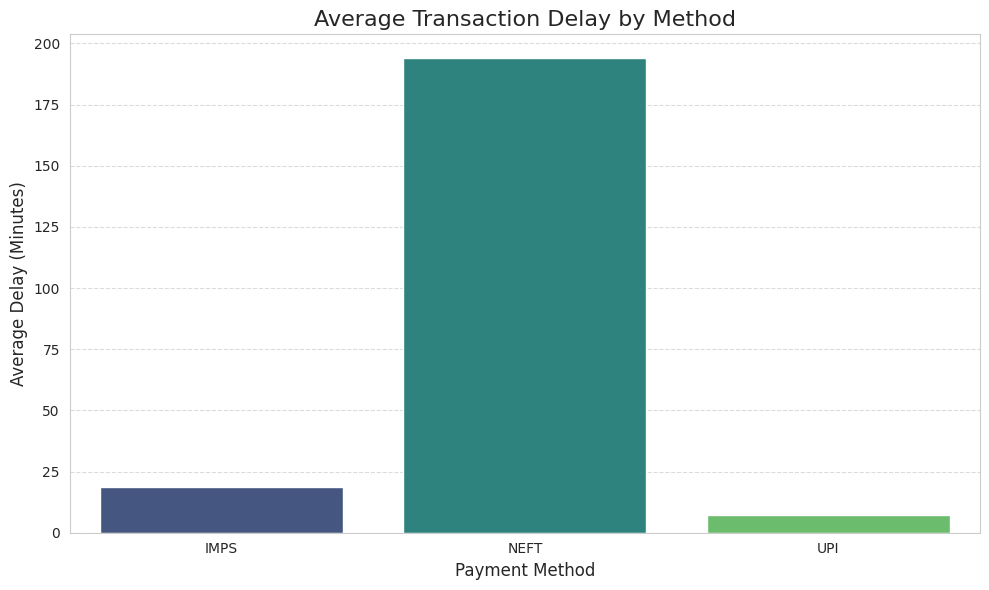

<ipython-input-38-298bddcdf573>:29: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(x='method', y='delay_minutes', data=resume_df, palette='viridis')


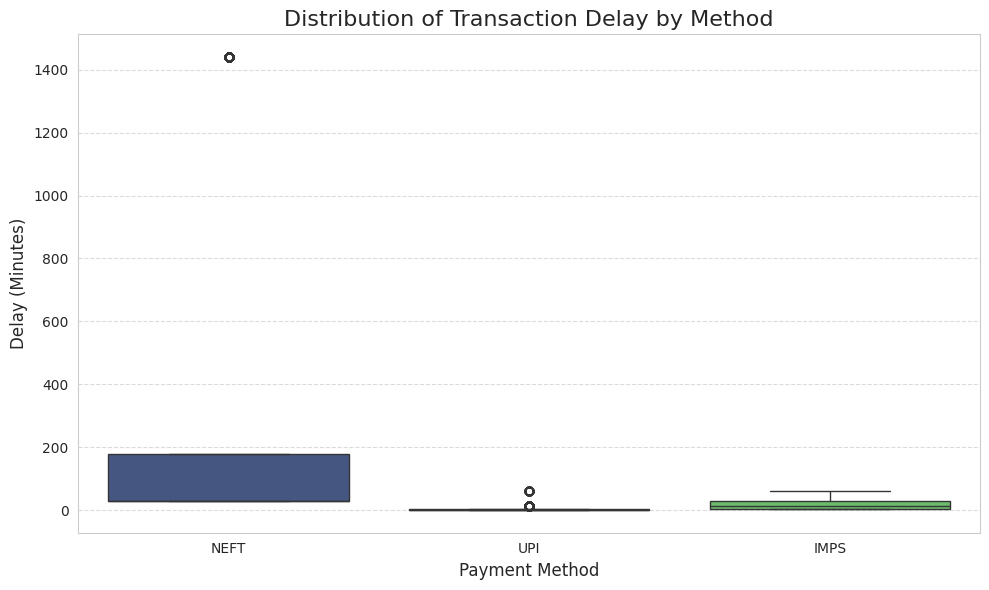

In [38]:
# Set a professional plotting style
import seaborn as sns # Import seaborn
import matplotlib.pyplot as plt # Import matplotlib

sns.set_style("whitegrid")
plt.rcParams['font.family'] = 'sans-serif' # Changed 'Inter' to 'sans-serif'

# --- Visualizations ---

# 1. Average Delay by Method (Bar Plot - Keep for clarity of average)
plt.figure(figsize=(10, 6))
sns.barplot(x='method', y='delay_minutes', data=avg_delay_by_method, palette='viridis')
plt.title('Average Transaction Delay by Method', fontsize=16)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Average Delay (Minutes)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()
# 1b. Distribution of Delay by Method (Box Plot - Provides more detail)
plt.figure(figsize=(10, 6))
sns.boxplot(x='method', y='delay_minutes', data=resume_df, palette='viridis')
plt.title('Distribution of Transaction Delay by Method', fontsize=16)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Delay (Minutes)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

<ipython-input-39-3b011723c836>:7: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bank', y='delay_minutes', data=avg_delay_by_bank.sort_values(by='delay_minutes', ascending=False).head(5), palette='magma')


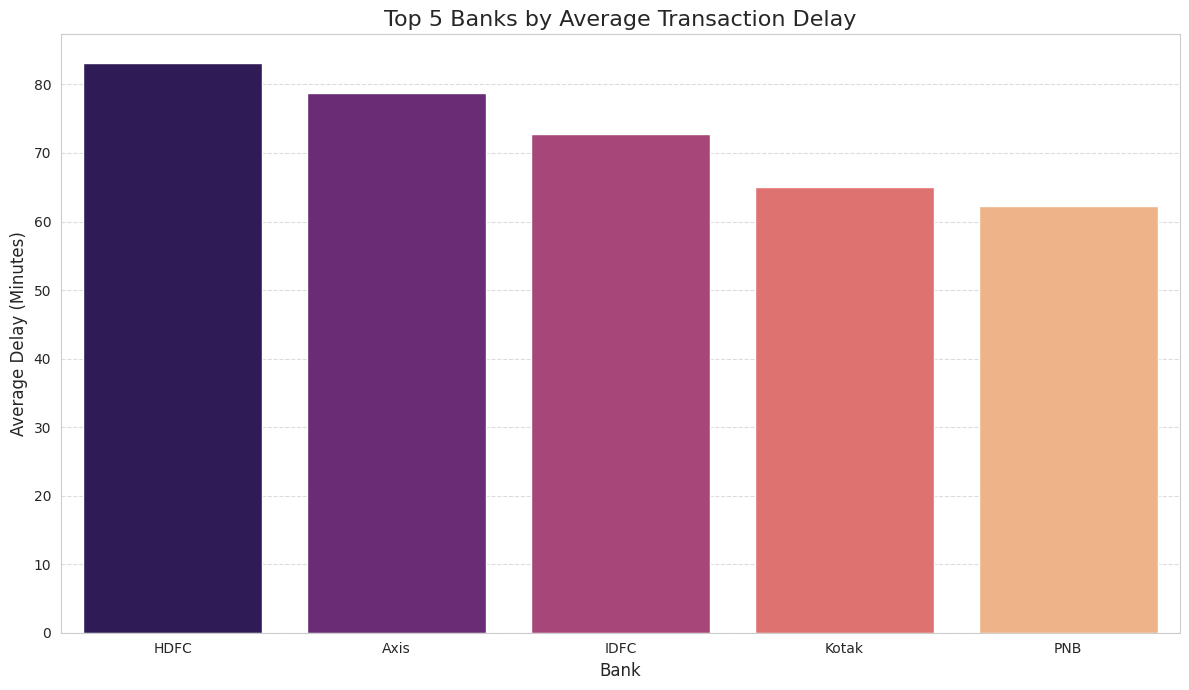

In [39]:
# 2. Average Delay by Bank (Top 5 Offenders)
plt.figure(figsize=(12, 7))
sns.barplot(x='bank', y='delay_minutes', data=avg_delay_by_bank.sort_values(by='delay_minutes', ascending=False).head(5), palette='magma')
plt.title('Top 5 Banks by Average Transaction Delay', fontsize=16)
plt.xlabel('Bank', fontsize=12)
plt.ylabel('Average Delay (Minutes)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

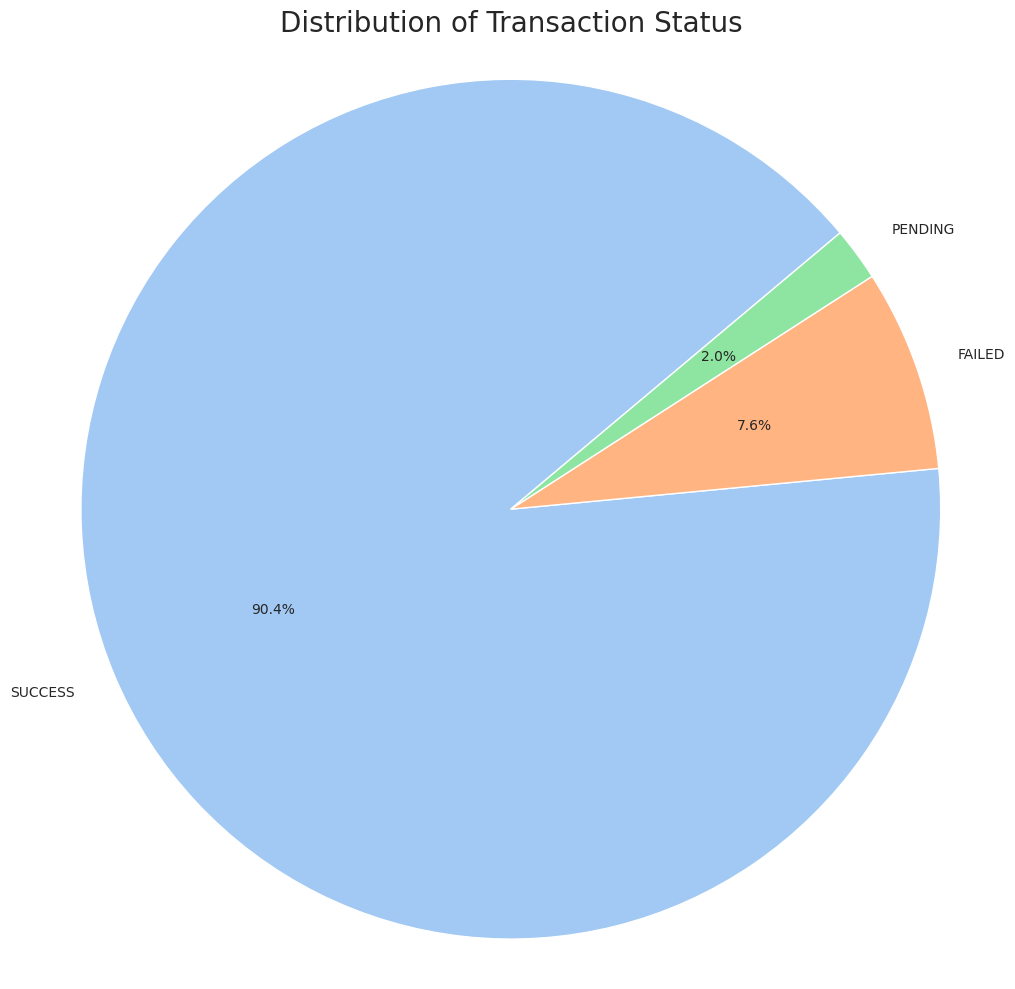

In [45]:
# 3. Transaction Status Distribution
plt.figure(figsize=(10, 10))
plt.pie(status_distribution, labels=status_distribution.index, autopct='%1.1f%%', startangle=40, colors=sns.color_palette('pastel'))
plt.title('Distribution of Transaction Status', fontsize=20)
plt.axis('equal')
plt.tight_layout()
plt.show()

<ipython-input-46-5aaa869f774f>:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=retry_attempts_distribution.index, y=retry_attempts_distribution.values, palette='cubehelix')


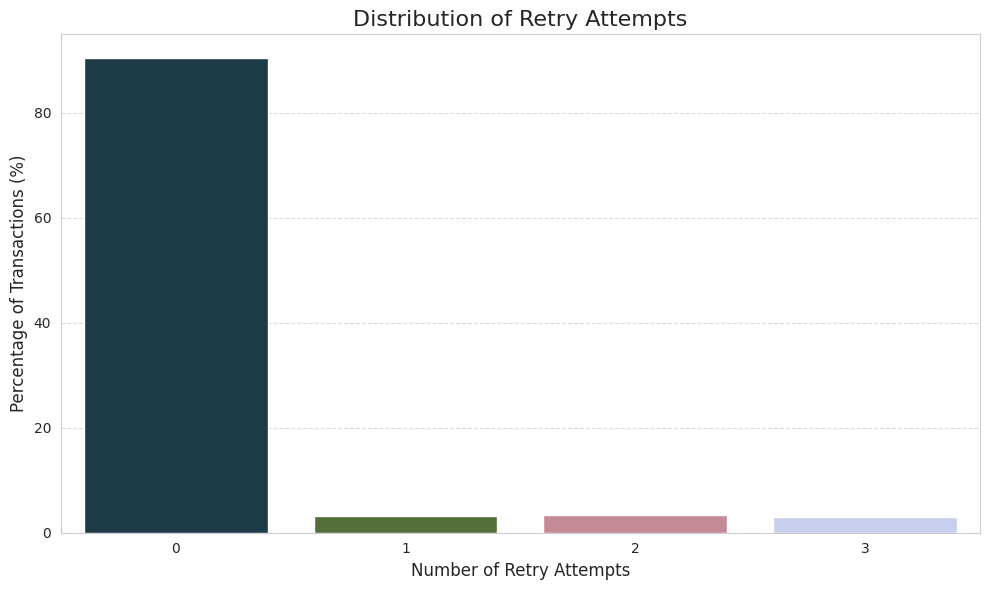

In [46]:
# 4. Retry Attempts Distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=retry_attempts_distribution.index, y=retry_attempts_distribution.values, palette='cubehelix')
plt.title('Distribution of Retry Attempts', fontsize=16)
plt.xlabel('Number of Retry Attempts', fontsize=12)
plt.ylabel('Percentage of Transactions (%)', fontsize=12)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()

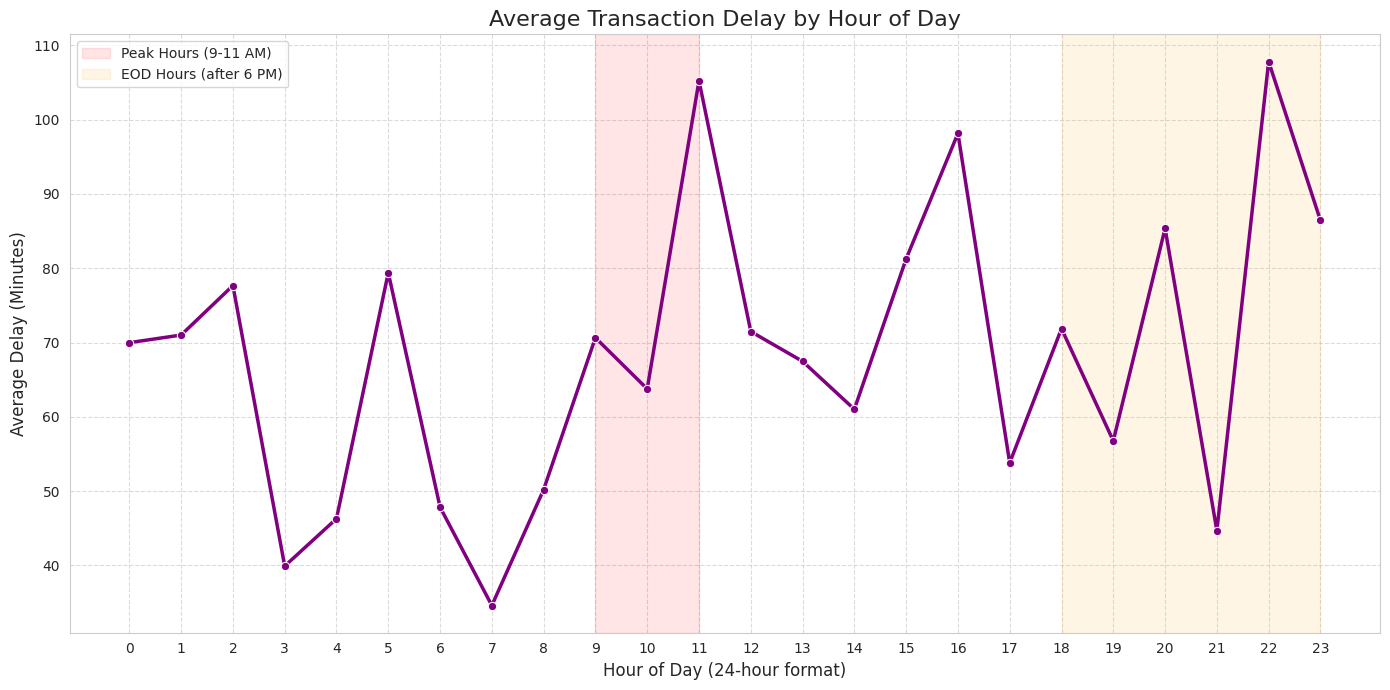

In [47]:
# 5. Hourly Average Delay (to show peak hour impact visually)
avg_delay_by_hour = resume_df.groupby('request_hour')['delay_minutes'].mean().reset_index()
plt.figure(figsize=(14, 7))
sns.lineplot(x='request_hour', y='delay_minutes', data=avg_delay_by_hour, marker='o', color='purple', linewidth=2.5)
plt.title('Average Transaction Delay by Hour of Day', fontsize=16)
plt.xlabel('Hour of Day (24-hour format)', fontsize=12)
plt.ylabel('Average Delay (Minutes)', fontsize=12)
plt.xticks(range(0, 24))
plt.grid(True, linestyle='--', alpha=0.7)
plt.axvspan(9, 11, color='red', alpha=0.1, label='Peak Hours (9-11 AM)') # Highlight peak morning hours
plt.axvspan(18, 23, color='orange', alpha=0.1, label='EOD Hours (after 6 PM)') # Highlight EOD hours
plt.legend()
plt.tight_layout()
plt.show()

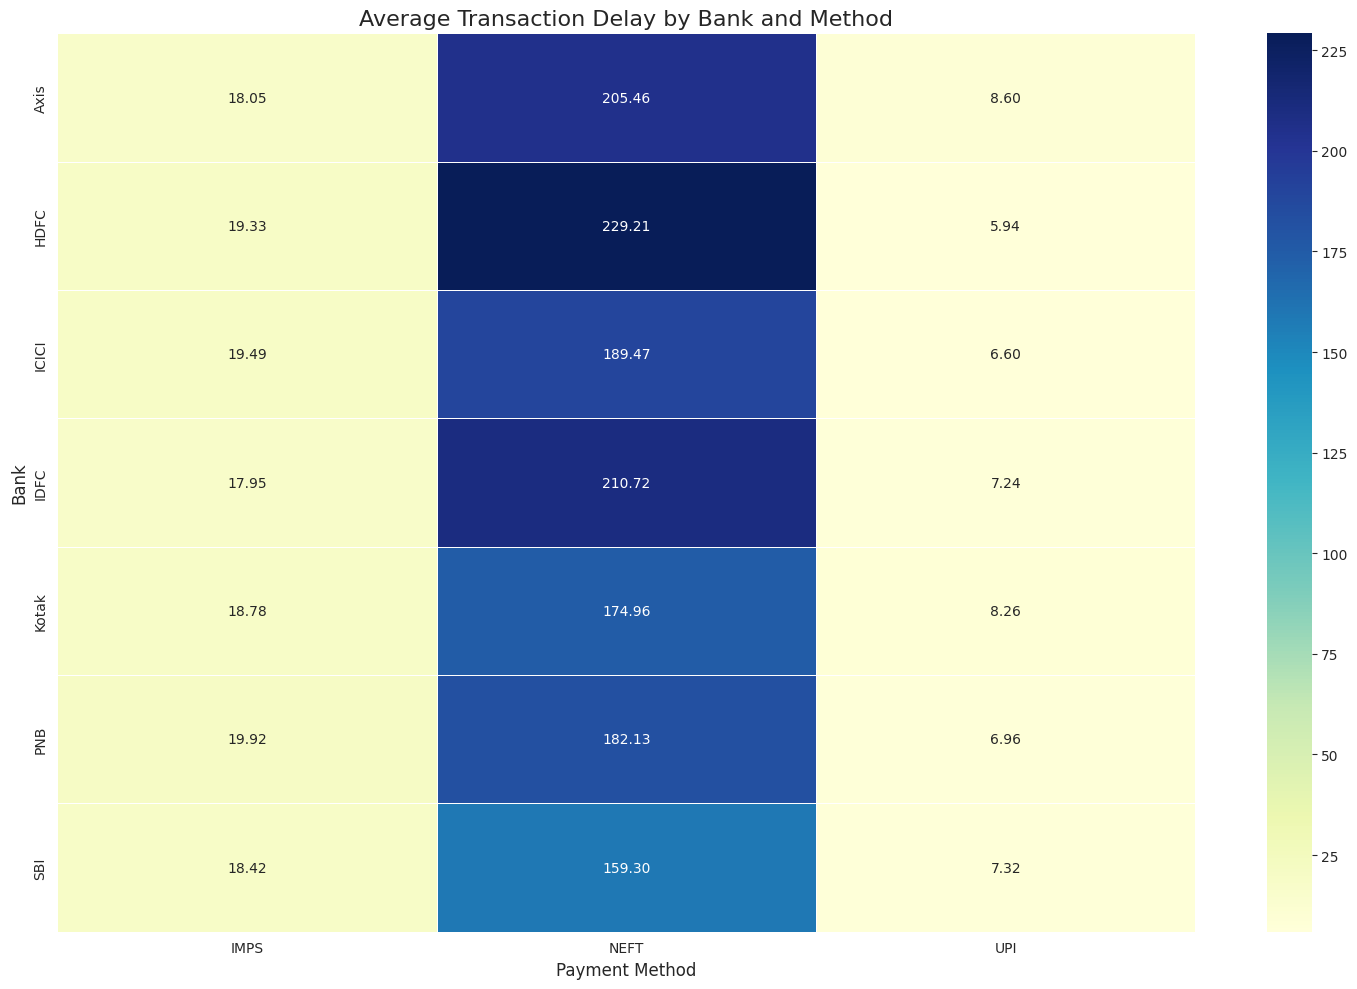

In [48]:
# 6. Heatmap of Average Delay by Method and Bank

average_delay_pivot = resume_df.pivot_table(index='bank', columns='method', values='delay_minutes', aggfunc='mean')

plt.figure(figsize=(15, 10)) # Adjust figure size for readability
sns.heatmap(average_delay_pivot, annot=True, fmt=".2f", cmap="YlGnBu", linewidths=.5)
plt.title('Average Transaction Delay by Bank and Method', fontsize=16)
plt.xlabel('Payment Method', fontsize=12)
plt.ylabel('Bank', fontsize=12)
plt.tight_layout()
plt.show()
